# Chargement des bibliotheques nécessaires

In [13]:
# bibliotheques mathematiques
import numpy as np

# bibliotheques pour les representations graphiques
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# bibliotheques pour le machine learning
import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
from sklearn.preprocessing import normalize

# bibliotheques pour le chargement des donnees
import csv
import pandas as pd

plt.ion()


In [14]:
def load_sub_sets(ratio_train, ratio_valid, train_csv, test_csv):
    data_train = np.genfromtxt(train_csv, delimiter=',', skip_header=1) # lecture du fichier train_csv
    y = data_train[:,0]                                                 # les labels
    X = data_train[:,1:]                                                # les donnees (sans leurs labels)
    
    Ntot   = X.shape[0]                                                 # nombre d'images dans les donnees X
    Ntrain = int(ratio_train*Ntot)                                      # nombre d'images pour l'entrainement
    Nvalid = int(ratio_valid*Ntot)                                      # nombre d'images pour la validation
    
    X_train = X[0: Ntrain].copy()                                       # les donnees qu'on utilise pour entrainer les modeles
    y_train = y[0: Ntrain].copy()                                       # les labels associes 
    
    X_valid = X[Ntrain:Ntrain+Nvalid].copy()                            # les donnees qu'on utilise pour tester les modeles
    y_valid = y[Ntrain:Ntrain+Nvalid].copy()                            # les labels associes
        
    data_test = np.genfromtxt(test_csv, delimiter=',', skip_header=1)   # lecture du fichier test_csv
    data_test = data_test[1:]                                           # donnees generales du fichier test_csv (celles que le modele ne connait pas)
    X_test  = data_test[:,1:]                                           # les labels
    y_test  = data_test[:,0]                                            # les donnees (sans leur label)
    
    return X, y, X_train, y_train, X_valid, y_valid, X_test, y_test

In [15]:
dim_repre = 28
ratio_train = 0.7
ratio_valid = 0.3

X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = load_sub_sets(ratio_train, ratio_valid, 'sign_mnist_train.csv', 'sign_mnist_test.csv')

# Affichage des données

On affiche quelques données du dataset sous la forme d'images

## Représentation de différentes données

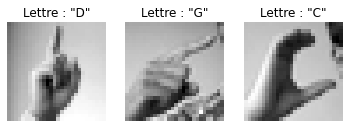

In [16]:
nb_displayed_dataset = 3
fig, ax = plt.subplots(1, nb_displayed_dataset)                         # creation de 3 subplots horizontaux

for i in range(nb_displayed_dataset):
    label_idx = int(y[i])                                               # on récupère l'indice alphabetique lié à la donnée
    letter_rep = chr(ord('A') + label_idx)                              # on transforme l'indice en lettre (eg. indice 0 devient 'A')
    ax[i].set_axis_off()                                                # on cache les axes
    ax[i].set_title(f'Lettre : "{letter_rep}"')                         # on affiche la lettre dans le titre
    ax[i].imshow(X[i].reshape(dim_repre, dim_repre), cm.gray)           # on affiche l'image sous la forme de nuance de gris en
                                                                        #  transformant la matrice linéaire en matrice carré

## Différentes représentations d'un même label

In [113]:
selected_label_idx = 0                                                  # on choisi d'afficher différentes représentations d'une lettre
selected_letter = chr(ord('A') + selected_label_idx)                    # la lettre selectionnée
only_A = (selected_label_idx == y)                                      # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
X_of_A = X[only_A]                                                      # on applique notre masque
print(f'Nous avons trouvés {X_of_A.shape[0]} représentations de la lettre {selected_letter}.')

Nous avons trouvés 1126 représentations de la lettre A.


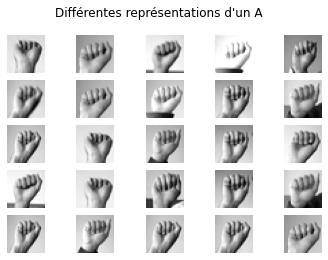

In [114]:
nb_subplots_by_ax = 5
fig, ax = plt.subplots(nb_subplots_by_ax, nb_subplots_by_ax)            # creation des subplots

fig.suptitle(f'Différentes représentations d\'un {selected_letter}')
for i in range(nb_subplots_by_ax):
    for j in range(nb_subplots_by_ax):
        idx = i*nb_subplots_by_ax + j                                   # on transforme le couple (i,j) en l'indice de l'image
        img = X_of_A[idx].reshape(dim_repre, dim_repre)                 # transformation de la matrice linéaire en matrice carré
        ax[i,j].set_axis_off()                                          # on cache les axes
        ax[i,j].imshow(img, cm.gray)                                    # on affiche l'image sous la forme de nuance de gris

# Preprocessing
## Sélection du meilleur nombre de composants

In [162]:
nb_comp_range = np.arange(1, 50, 2)                                     # axe du nombre de composants

training_scores = []                                                    # tableau des scores d'entrainement en fonction du nombre de composants séléctionné
valid_scores = []                                                       # tableau des scores de validation en fonction du nombre de composants séléctionné
tab_result = pd.DataFrame(columns=[
    'score d\'entrainement',
    'score de validation',
    'différence'])                                                      # tableau récapitulatif

for nb_comp in nb_comp_range:
    pre_proc = sklearn.decomposition.PCA(n_components=nb_comp)          # création d'un PCA permettant la compression des images en nb_comp pixels
    pre_proc.fit(X)                                                     # entrainement du modèle PCA
    X_train_transformed = pre_proc.transform(X_train)                   # transformation des données d'entrainement en fonction du PCA
    X_valid_transformed = pre_proc.transform(X_valid)                   # transformation des données de validation en fonction du PCA
    
    clf = sklearn.svm.SVC(kernel='poly', coef0=1, degree=2)             # on choisit un classifieur SVC
    clf.fit(X_train_transformed, y_train)                               # on entraine notre classifieur avec X_train_transformed
    
    train_score = clf.score(X_train_transformed, y_train)               # on récupère les scores liés (entrainement)
    valid_score = clf.score(X_valid_transformed, y_valid)               # on récupère les scores liés (validation)
    
    tab_result.loc[f'{nb_comp} composants'] = np.array([
        f'{train_score * 100:.2f}%',
        f'{valid_score * 100:.2f}%',
        f'{(train_score-valid_score) * 100:.2f}%'])                     # ajout des données dans le tableau récapitulatif (en pourcentage)

    training_scores.append(train_score * 100)                           # on sauvegarde les scores d'entrainement pour les statistiques
    valid_scores.append(valid_score * 100)                              # on sauvegarde les scores de validation pour les statistiques

training_scores = np.array(training_scores)
valid_scores = np.array(valid_scores)

tab_result

,score d'entrainement,score de validation,différence
1 composants,6.97%,6.88%,0.09%
3 composants,21.63%,21.52%,0.12%
5 composants,38.07%,37.01%,1.07%
7 composants,59.27%,58.52%,0.74%
9 composants,76.74%,75.41%,1.33%
11 composants,84.27%,83.39%,0.88%
13 composants,90.53%,90.25%,0.28%
15 composants,94.04%,93.78%,0.25%
17 composants,95.90%,95.98%,-0.08%
19 composants,96.82%,96.84%,-0.02%


In [196]:
n_comps_rank = [0 for i in range(len(training_scores))]

def update_rank(data, reverse=False):
    global n_comps_rank
    normalized_data = data / 100
    for i, x in enumerate(normalized_data):
        n_comps_rank[i] += -x if reverse else x

def get_best_n_comps():
    global n_comps_rank
    ranks = sorted(enumerate(n_comps_rank), key=lambda x: x[1], reverse=True)
    formated_ranks = [(nb_comp_range[i], score) for i, score in ranks]
    return tuple(zip(*formated_ranks))

Meilleur nombre de composants pour maximiser le score : 47



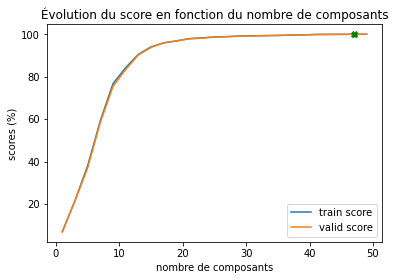

In [197]:
plt.title('Évolution du score en fonction du nombre de composants')
plt.plot(nb_comp_range, training_scores, label='train score')
plt.plot(nb_comp_range, valid_scores, label='valid score')
plt.xlabel('nombre de composants')
plt.ylabel('scores (%)')
plt.legend()

best_index = np.argmax(valid_scores)
best_n_comp = nb_comp_range[best_index]
plt.plot(best_n_comp, valid_scores[best_index], marker='X', color='green')

print(f'Meilleur nombre de composants pour maximiser le score : {best_n_comp}\n')

update_rank(valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 17



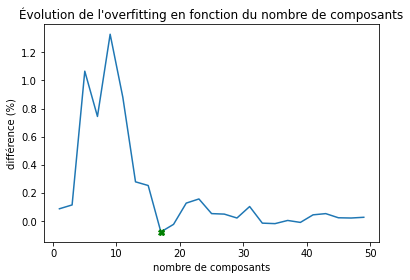

In [198]:
diff_scores = training_scores - valid_scores

plt.title('Évolution de l\'overfitting en fonction du nombre de composants')
plt.plot(nb_comp_range, diff_scores)
plt.xlabel('nombre de composants')
plt.ylabel('différence (%)')

best_index = np.argmin(diff_scores)
best_n_comp = nb_comp_range[best_index]
plt.plot(best_n_comp, diff_scores[best_index], marker='X', color='green')

print(f'Meilleur nombre de composants pour minimiser l\'overfitting : {best_n_comp}\n')

update_rank(diff_scores, reverse=True)

Meilleur nombre de composants pour maximiser le gain de score : 7



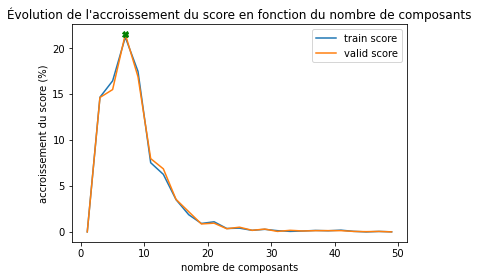

In [199]:
training_scores_incr = np.array([score - training_scores[i-1] if i != 0 else 0 for i, score in enumerate(training_scores)])
valid_scores_incr = np.array([score - valid_scores[i-1] if i != 0 else 0 for i, score in enumerate(valid_scores)])

plt.title('Évolution de l\'accroissement du score en fonction du nombre de composants')
plt.plot(nb_comp_range, training_scores_incr, label='train score')
plt.plot(nb_comp_range, valid_scores_incr, label='valid score')
plt.xlabel('nombre de composants')
plt.ylabel('accroissement du score (%)')
plt.legend()

best_index = np.argmax(valid_scores_incr)
best_n_comp = nb_comp_range[best_index]
plt.plot(best_n_comp, valid_scores_incr[best_index], marker='X', color='green')

print(f'Meilleur nombre de composants pour maximiser le gain de score : {best_n_comp}\n')

update_rank(valid_scores_incr)

Meilleur nombre de composants : 13



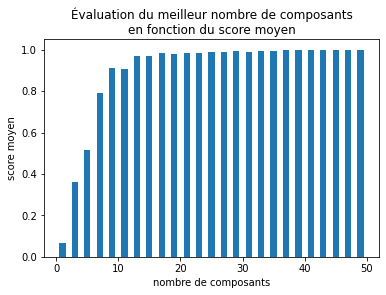

In [206]:
x_nb_comps, y_score = get_best_n_comps()

plt.title('Évaluation du meilleur nombre de composants\nen fonction du score moyen')
plt.bar(x_nb_comps, y_score, width=1)
plt.xlabel('nombre de composants')
plt.ylabel('score moyen')

best_nb_comps, best_score = -1, -1
tolerance = 1.01

for nb_comps, score in zip(x_nb_comps, y_score):
    if score*tolerance > best_score:
        best_nb_comps = nb_comps
        best_score = score

print(f'Meilleur nombre de composants : {best_nb_comps}\n')

### on prepare nos données

In [23]:
nbCompOptimal = 16
#car bon score + plafone un peu après + nombre de composants le plus limités possible

In [24]:
#on prépare nos données en les optimisants

preProc = sklearn.decomposition.PCA(n_components = nbCompOptimal)
preProc.fit(X)

X_train_transformed = preProc.transform(X_train)
X_valid_transformed = preProc.transform(X_valid)

X_train_decompressees = preProc.inverse_transform(X_train_transformed)

In [25]:
plt.figure()
plt.imshow(X_train_decompressees[idx].reshape(dimRepre, dimRepre), cm.gray)

NameError: name 'dimRepre' is not defined

### comparaison pour une autre svm : LinearSVC

In [12]:
clfLinearSVC = sklearn.svm.LinearSVC()
clfLinearSVC.fit(normalize(X_train_transformed), y_train)

trainscore = clfLinearSVC.score(X_train_transformed, y_train)
validscore = clfLinearSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", str(nbCompOptimal) , "   training score:",trainscore, ". valid score:", validscore)

nombre Composants 16    training score: 0.36533458216255593 . valid score: 0.3674113647401651


##### on teste le modele LinearSVC sans PCA

In [13]:
clfLinearSVC2 = sklearn.svm.LinearSVC()
clfLinearSVC2.fit(normalize(X_train), y_train)

trainscore = clfLinearSVC2.score(X_train, y_train)
validscore = clfLinearSVC2.score(X_valid, y_valid)
print("training score:",trainscore, ". valid score:", validscore)

training score: 0.2780726402331148 . valid score: 0.26748421563865954


##### on teste le modele LinearSVC avec PCA avec beaucoup de composants

In [14]:
#compression des images en n_components pixels
preProc3 = sklearn.decomposition.PCA(n_components = 700)
#entrainement
preProc3.fit(X)
#X_train_transformed = les donnees de X_train entraines, idem pour X_valid_transformed
X_train_transformed3 = preProc.transform(X_train)
X_valid_transformed3 = preProc.transform(X_valid)

In [15]:
clfLinearSVC3 = sklearn.svm.LinearSVC()
clfLinearSVC3.fit(normalize(X_train_transformed3), y_train)

trainscore = clfLinearSVC3.score(X_train_transformed3, y_train)
validscore = clfLinearSVC3.score(X_valid_transformed3, y_valid)
print("nombre Composants", str(700) , "   training score:",trainscore, ". valid score:", validscore)

nombre Composants 700    training score: 0.36533458216255593 . valid score: 0.3674113647401651


## Comparaison SVC (avec kernel linéaire)

In [ ]:
clfLinearSVC =sklearn.svm.SVC(C =1, kernel = 'linear', coef0 = 1)
clfLinearSVC.fit(normalize(X_train_transformed), y_train)

trainscore = clfLinearSVC.score(X_train_transformed, y_train)
validscore = clfLinearSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", str(nbCompOptimal) , "   training score:",trainscore, ". valid score:", validscore)

### comparaison pour une autre svm : NuSVC

In [16]:
clfNuSVC = sklearn.svm.NuSVC(nu=0.7, kernel='poly', coef0=1, degree=2)
clfNuSVC.fit(X_train_transformed, y_train)

trainscore = clfNuSVC.score(X_train_transformed, y_train)
validscore = clfNuSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", str(nbCompOptimal) , "   training score:",trainscore, ". valid score:", validscore)

nombre Composants 16    training score: 0.6125507336871683 . valid score: 0.6008984944147644


##### on teste le modele NuSVC sans PCA

In [ ]:
clfNuSVC2 = sklearn.svm.NuSVC(nu=0.7, kernel='poly', coef0=1, degree=2)
clfNuSVC2.fit(X_train, y_train)

trainscore = clfNuSVC2.score(X_train, y_train)
validscore = clfNuSVC2.score(X_valid, y_valid)
print("training score:",trainscore, ". valid score:", validscore)

### cross-validation

In [ ]:
num_folds = 10
kfold = sklearn.model_selection.KFold(n_splits=num_folds)
kfold

In [ ]:
monScoring = sklearn.model_selection.cross_val_score(estimator = clf, X = X, y = y, cv= kfold, scoring= 'neg_mean_squared_error')